In [1]:
import numpy as np
from glob import glob
import os
import matplotlib.pyplot as plt
import pandas as pd

import torch
import torchvision
from torchvision.io import read_image
from torch.utils.data import Dataset
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.io import read_image
import torch.optim as optim
import torchvision.models as models
import torch.nn as nn

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

from coco_eval import CocoEvaluator
from coco_utils import get_coco_api_from_dataset

from engine import train_one_epoch, evaluate

In [2]:
DATA_PATH = '/home/saad/data/rob535/'
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [3]:
train_split = 0.8

# input_size = 224
input_size = 224

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

criterion = nn.CrossEntropyLoss()

NUM_EPOCHS = 25
BATCH_SIZE = 8

WEIGHT_DECAY = 0.01
LR = 0.003

HIDDEN_SIZE = 1000

In [4]:
def rot(n):
    n = np.asarray(n).flatten()
    assert(n.size == 3)

    theta = np.linalg.norm(n)
    if theta:
        n /= theta
        K = np.array([[0, -n[2], n[1]], [n[2], 0, -n[0]], [-n[1], n[0], 0]])

        return np.identity(3) + np.sin(theta) * K + (1 - np.cos(theta)) * K @ K
    else:
        return np.identity(3)


def get_bbox(p0, p1):
    """
    Input:
    *   p0, p1
        (3)
        Corners of a bounding box represented in the body frame.

    Output:/
    *   v
        (3, 8)
        Vertices of the bounding box represented in the body frame.
    *   e
        (2, 14)
        Edges of the bounding box. The first 2 edges indicate the `front` side
        of the box.
    """
    v = np.array([
        [p0[0], p0[0], p0[0], p0[0], p1[0], p1[0], p1[0], p1[0]],
        [p0[1], p0[1], p1[1], p1[1], p0[1], p0[1], p1[1], p1[1]],
        [p0[2], p1[2], p0[2], p1[2], p0[2], p1[2], p0[2], p1[2]]
    ])
    e = np.array([
        [2, 3, 0, 0, 3, 3, 0, 1, 2, 3, 4, 4, 7, 7],
        [7, 6, 1, 2, 1, 2, 4, 5, 6, 7, 5, 6, 5, 6]
    ], dtype=np.uint8)

    return v, e

def process_bbox(bbox, proj, img):
    R = rot(bbox[0, 0:3])
    t = bbox[0, 3:6]

    sz = bbox[0, 6:9]
    vert_3D, edges = get_bbox(-sz / 2, sz / 2)
    vert_3D = R @ vert_3D + t[:, np.newaxis]

    vert_2D = proj @ np.vstack([vert_3D, np.ones(vert_3D.shape[1])])
    vert_2D = vert_2D / vert_2D[2, :]
    lmin = max(np.min(vert_2D[0, :]), 0)
    lmax = min(np.max(vert_2D[0, :]), img.shape[2])
    umin = max(np.min(vert_2D[1, :]), 0)
    umax = min(np.max(vert_2D[1, :]), img.shape[1])
    
    return [[lmin, umin, lmax, umax]]

In [5]:
# Data loader
class CustomImageDataset(Dataset):
    def __init__(self, img_dir, label_info, transform=None, target_transform=None):
        self.label_info = label_info
        self.shuffle_data()
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def shuffle_data(self):
        self.label_info = self.label_info.sample(frac=1)
        self.img_labels = self.label_info["label"].values.tolist()
        self.img_files = self.label_info["guid/image"].values.tolist()

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_files[idx]) + "_image.jpg"
        bbox_path = os.path.join(self.img_dir, self.img_files[idx]) + "_bbox.bin"
        proj_path = os.path.join(self.img_dir, self.img_files[idx]) + "_proj.bin"
        image = read_image(img_path).float() * 1.0/255
        obj_ids = np.array([1, 2])
        num_objs = 2
        
        
        labels = torch.ones((num_objs,), dtype=torch.int64)
        bbox = np.fromfile(bbox_path, np.float32).reshape([-1, 11])
        proj = np.fromfile(proj_path, np.float32).reshape([3, 4])
        boxes = torch.as_tensor(process_bbox(bbox, proj, image), dtype=torch.float32)

    
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
        
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = torch.tensor([idx])
        target["area"] = area
        target["iscrowd"] = iscrowd

        return image, target

In [6]:
# Shuffle, Split Data into train/val
label_info = pd.read_csv(os.path.join(DATA_PATH, "trainval", "labels.csv"))
label_info = label_info.sample(frac=1)

split_point = int(train_split * label_info["label"].size) 

img_dir = os.path.join(DATA_PATH, "trainval")


training_data = CustomImageDataset(img_dir, label_info[:split_point])
val_data = CustomImageDataset(img_dir, label_info[split_point:])

train_dataloader = DataLoader(training_data, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True)

dataloaders = {
    "train": train_dataloader,
    "val": val_dataloader
}

# Training

In [7]:
def create_model(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    
    model = model.to(device)

    # construct an optimizer
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.01,
                            momentum=0.9, weight_decay=0.0005)
    
    optimizer = optim.SGD(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY, momentum=0.9, nesterov=True)
    return model, optimizer
    
    

In [8]:
num_classes = 2

model, optimizer = create_model(num_classes)
model.to(device)


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [9]:
num_epochs = 20

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, dataloaders['train'], device, epoch, print_freq=10)

    # and a learning rate scheduler which decreases the learning rate by
    # 10x every 3 epochs
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                   step_size=3,
                                                   gamma=0.1)
    
    # evaluate on the test dataset
    evaluate(model, dataloaders['val'], device=device)


/home/saad/envs/sdc/lib/python3.7/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Epoch: [0]  [  0/467]  eta: 0:09:52  lr: 0.000009  loss: 0.9181 (0.9181)  loss_classifier: 0.7635 (0.7635)  loss_box_reg: 0.1242 (0.1242)  loss_objectness: 0.0175 (0.0175)  loss_rpn_box_reg: 0.0129 (0.0129)  time: 1.2689  data: 0.1810  max mem: 8958
Epoch: [0]  [ 10/467]  eta: 0:09:32  lr: 0.000074  loss: 0.8661 (0.8357)  loss_classifier: 0.6843 (0.6619)  loss_box_reg: 0.1356 (0.1432)  loss_objectness: 0.0175 (0.0228)  loss_rpn_box_reg: 0.0039 (0.0078)  time: 1.2524  data: 0.1842  max mem: 9222
Epoch: [0]  [ 20/467]  eta: 0:09:18  lr: 0.000138  loss: 0.5536 (0.6415)  loss_classifier: 0.4358 (0.4702)  loss_box_reg: 0.1394 (0.1446)  loss_objectness: 0.0165 (0.0197)  loss_rpn_box_reg: 0.0039 (0.0070)  time: 1.2493  data: 0.1810  max mem: 9222
Epoch: [0]  [ 30/467]  eta: 0:09:06  lr: 0.000202  loss: 0.3139 (0.5255)  loss_classifier: 0.1328 (0.3552)  loss_box_reg: 0.1330 (0.1406)  loss_objectness: 0.0167 (0.0218)  loss_rpn_box_reg: 0.0061 (0.0078)  time: 1.2485  data: 0.1758  max mem: 9222


Epoch: [0]  [330/467]  eta: 0:02:54  lr: 0.002132  loss: 0.0739 (0.1739)  loss_classifier: 0.0239 (0.0713)  loss_box_reg: 0.0488 (0.0920)  loss_objectness: 0.0021 (0.0074)  loss_rpn_box_reg: 0.0015 (0.0032)  time: 1.2814  data: 0.1907  max mem: 9222
Epoch: [0]  [340/467]  eta: 0:02:41  lr: 0.002196  loss: 0.0876 (0.1715)  loss_classifier: 0.0252 (0.0700)  loss_box_reg: 0.0530 (0.0909)  loss_objectness: 0.0012 (0.0073)  loss_rpn_box_reg: 0.0015 (0.0032)  time: 1.2810  data: 0.1901  max mem: 9222
Epoch: [0]  [350/467]  eta: 0:02:28  lr: 0.002260  loss: 0.0829 (0.1688)  loss_classifier: 0.0252 (0.0688)  loss_box_reg: 0.0482 (0.0896)  loss_objectness: 0.0023 (0.0072)  loss_rpn_box_reg: 0.0015 (0.0031)  time: 1.2806  data: 0.1876  max mem: 9222
Epoch: [0]  [360/467]  eta: 0:02:16  lr: 0.002325  loss: 0.0742 (0.1662)  loss_classifier: 0.0217 (0.0675)  loss_box_reg: 0.0431 (0.0885)  loss_objectness: 0.0023 (0.0071)  loss_rpn_box_reg: 0.0016 (0.0031)  time: 1.2765  data: 0.1823  max mem: 9222


Epoch: [1]  [120/467]  eta: 0:07:14  lr: 0.003000  loss: 0.0623 (0.0695)  loss_classifier: 0.0173 (0.0234)  loss_box_reg: 0.0366 (0.0431)  loss_objectness: 0.0008 (0.0018)  loss_rpn_box_reg: 0.0008 (0.0013)  time: 1.2539  data: 0.1606  max mem: 9222
Epoch: [1]  [130/467]  eta: 0:07:01  lr: 0.003000  loss: 0.0610 (0.0697)  loss_classifier: 0.0200 (0.0233)  loss_box_reg: 0.0347 (0.0428)  loss_objectness: 0.0007 (0.0023)  loss_rpn_box_reg: 0.0009 (0.0013)  time: 1.2556  data: 0.1627  max mem: 9222
Epoch: [1]  [140/467]  eta: 0:06:49  lr: 0.003000  loss: 0.0723 (0.0700)  loss_classifier: 0.0212 (0.0231)  loss_box_reg: 0.0423 (0.0431)  loss_objectness: 0.0010 (0.0023)  loss_rpn_box_reg: 0.0012 (0.0014)  time: 1.2577  data: 0.1630  max mem: 9222
Epoch: [1]  [150/467]  eta: 0:06:37  lr: 0.003000  loss: 0.0725 (0.0700)  loss_classifier: 0.0212 (0.0230)  loss_box_reg: 0.0450 (0.0431)  loss_objectness: 0.0015 (0.0024)  loss_rpn_box_reg: 0.0013 (0.0014)  time: 1.2646  data: 0.1687  max mem: 9222


Epoch: [1]  [450/467]  eta: 0:00:21  lr: 0.003000  loss: 0.0547 (0.0683)  loss_classifier: 0.0205 (0.0230)  loss_box_reg: 0.0343 (0.0418)  loss_objectness: 0.0006 (0.0021)  loss_rpn_box_reg: 0.0009 (0.0014)  time: 1.2555  data: 0.1609  max mem: 9222
Epoch: [1]  [460/467]  eta: 0:00:08  lr: 0.003000  loss: 0.0586 (0.0681)  loss_classifier: 0.0198 (0.0230)  loss_box_reg: 0.0357 (0.0417)  loss_objectness: 0.0008 (0.0021)  loss_rpn_box_reg: 0.0010 (0.0014)  time: 1.2557  data: 0.1622  max mem: 9222
Epoch: [1]  [466/467]  eta: 0:00:01  lr: 0.003000  loss: 0.0581 (0.0680)  loss_classifier: 0.0188 (0.0229)  loss_box_reg: 0.0350 (0.0416)  loss_objectness: 0.0009 (0.0020)  loss_rpn_box_reg: 0.0009 (0.0014)  time: 1.2235  data: 0.1624  max mem: 9222
Epoch: [1] Total time: 0:09:45 (1.2537 s / it)
creating index...
index created!
Test:  [  0/117]  eta: 0:01:27  model_time: 0.4916 (0.4916)  evaluator_time: 0.0035 (0.0035)  time: 0.7439  data: 0.2257  max mem: 9222
Test:  [100/117]  eta: 0:00:12  mo

Epoch: [2]  [240/467]  eta: 0:04:46  lr: 0.003000  loss: 0.0604 (0.0635)  loss_classifier: 0.0191 (0.0219)  loss_box_reg: 0.0367 (0.0384)  loss_objectness: 0.0008 (0.0019)  loss_rpn_box_reg: 0.0012 (0.0014)  time: 1.2624  data: 0.1682  max mem: 9222
Epoch: [2]  [250/467]  eta: 0:04:33  lr: 0.003000  loss: 0.0594 (0.0634)  loss_classifier: 0.0200 (0.0218)  loss_box_reg: 0.0367 (0.0383)  loss_objectness: 0.0009 (0.0019)  loss_rpn_box_reg: 0.0014 (0.0014)  time: 1.2608  data: 0.1672  max mem: 9222
Epoch: [2]  [260/467]  eta: 0:04:20  lr: 0.003000  loss: 0.0564 (0.0636)  loss_classifier: 0.0200 (0.0219)  loss_box_reg: 0.0360 (0.0384)  loss_objectness: 0.0009 (0.0019)  loss_rpn_box_reg: 0.0011 (0.0014)  time: 1.2575  data: 0.1614  max mem: 9222
Epoch: [2]  [270/467]  eta: 0:04:08  lr: 0.003000  loss: 0.0732 (0.0639)  loss_classifier: 0.0226 (0.0220)  loss_box_reg: 0.0397 (0.0385)  loss_objectness: 0.0006 (0.0020)  loss_rpn_box_reg: 0.0011 (0.0014)  time: 1.2575  data: 0.1616  max mem: 9222


Epoch: [3]  [ 30/467]  eta: 0:09:06  lr: 0.003000  loss: 0.0518 (0.0629)  loss_classifier: 0.0198 (0.0227)  loss_box_reg: 0.0338 (0.0371)  loss_objectness: 0.0009 (0.0018)  loss_rpn_box_reg: 0.0011 (0.0013)  time: 1.2515  data: 0.1607  max mem: 9222
Epoch: [3]  [ 40/467]  eta: 0:08:54  lr: 0.003000  loss: 0.0643 (0.0633)  loss_classifier: 0.0201 (0.0226)  loss_box_reg: 0.0387 (0.0374)  loss_objectness: 0.0013 (0.0019)  loss_rpn_box_reg: 0.0014 (0.0014)  time: 1.2539  data: 0.1610  max mem: 9222
Epoch: [3]  [ 50/467]  eta: 0:08:42  lr: 0.003000  loss: 0.0584 (0.0618)  loss_classifier: 0.0200 (0.0220)  loss_box_reg: 0.0371 (0.0366)  loss_objectness: 0.0015 (0.0019)  loss_rpn_box_reg: 0.0014 (0.0014)  time: 1.2556  data: 0.1615  max mem: 9222
Epoch: [3]  [ 60/467]  eta: 0:08:30  lr: 0.003000  loss: 0.0558 (0.0617)  loss_classifier: 0.0195 (0.0221)  loss_box_reg: 0.0333 (0.0364)  loss_objectness: 0.0013 (0.0018)  loss_rpn_box_reg: 0.0013 (0.0014)  time: 1.2563  data: 0.1621  max mem: 9222


Epoch: [3]  [360/467]  eta: 0:02:14  lr: 0.003000  loss: 0.0653 (0.0663)  loss_classifier: 0.0242 (0.0241)  loss_box_reg: 0.0381 (0.0384)  loss_objectness: 0.0015 (0.0023)  loss_rpn_box_reg: 0.0016 (0.0016)  time: 1.2601  data: 0.1620  max mem: 9222
Epoch: [3]  [370/467]  eta: 0:02:02  lr: 0.003000  loss: 0.0759 (0.0664)  loss_classifier: 0.0257 (0.0241)  loss_box_reg: 0.0422 (0.0385)  loss_objectness: 0.0023 (0.0023)  loss_rpn_box_reg: 0.0017 (0.0016)  time: 1.2586  data: 0.1608  max mem: 9222
Epoch: [3]  [380/467]  eta: 0:01:49  lr: 0.003000  loss: 0.0697 (0.0665)  loss_classifier: 0.0246 (0.0241)  loss_box_reg: 0.0405 (0.0385)  loss_objectness: 0.0018 (0.0023)  loss_rpn_box_reg: 0.0014 (0.0016)  time: 1.2584  data: 0.1597  max mem: 9222
Epoch: [3]  [390/467]  eta: 0:01:36  lr: 0.003000  loss: 0.0712 (0.0670)  loss_classifier: 0.0246 (0.0242)  loss_box_reg: 0.0402 (0.0387)  loss_objectness: 0.0031 (0.0025)  loss_rpn_box_reg: 0.0016 (0.0016)  time: 1.2600  data: 0.1621  max mem: 9222


Epoch: [4]  [150/467]  eta: 0:06:42  lr: 0.003000  loss: 0.0673 (0.0723)  loss_classifier: 0.0246 (0.0263)  loss_box_reg: 0.0390 (0.0410)  loss_objectness: 0.0019 (0.0032)  loss_rpn_box_reg: 0.0016 (0.0019)  time: 1.2691  data: 0.1712  max mem: 9222
Epoch: [4]  [160/467]  eta: 0:06:29  lr: 0.003000  loss: 0.0623 (0.0722)  loss_classifier: 0.0238 (0.0262)  loss_box_reg: 0.0378 (0.0408)  loss_objectness: 0.0018 (0.0032)  loss_rpn_box_reg: 0.0015 (0.0019)  time: 1.2696  data: 0.1727  max mem: 9222
Epoch: [4]  [170/467]  eta: 0:06:16  lr: 0.003000  loss: 0.0694 (0.0724)  loss_classifier: 0.0242 (0.0263)  loss_box_reg: 0.0390 (0.0409)  loss_objectness: 0.0018 (0.0033)  loss_rpn_box_reg: 0.0015 (0.0019)  time: 1.2693  data: 0.1742  max mem: 9222
Epoch: [4]  [180/467]  eta: 0:06:04  lr: 0.003000  loss: 0.0814 (0.0733)  loss_classifier: 0.0282 (0.0267)  loss_box_reg: 0.0450 (0.0413)  loss_objectness: 0.0029 (0.0033)  loss_rpn_box_reg: 0.0017 (0.0019)  time: 1.2685  data: 0.1739  max mem: 9222


creating index...
index created!
Test:  [  0/117]  eta: 0:01:31  model_time: 0.5117 (0.5117)  evaluator_time: 0.0034 (0.0034)  time: 0.7814  data: 0.2431  max mem: 9222
Test:  [100/117]  eta: 0:00:12  model_time: 0.4793 (0.4799)  evaluator_time: 0.0034 (0.0035)  time: 0.7336  data: 0.2291  max mem: 9222
Test:  [116/117]  eta: 0:00:00  model_time: 0.4815 (0.4787)  evaluator_time: 0.0034 (0.0035)  time: 0.7199  data: 0.2237  max mem: 9222
Test: Total time: 0:01:25 (0.7314 s / it)
Averaged stats: model_time: 0.4815 (0.4787)  evaluator_time: 0.0034 (0.0035)
Accumulating evaluation results...
DONE (t=0.06s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.692
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.956
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.782
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=me

Epoch: [5]  [270/467]  eta: 0:04:08  lr: 0.003000  loss: 0.0801 (0.0798)  loss_classifier: 0.0282 (0.0296)  loss_box_reg: 0.0453 (0.0439)  loss_objectness: 0.0029 (0.0041)  loss_rpn_box_reg: 0.0021 (0.0021)  time: 1.2660  data: 0.1646  max mem: 9222
Epoch: [5]  [280/467]  eta: 0:03:56  lr: 0.003000  loss: 0.0770 (0.0799)  loss_classifier: 0.0276 (0.0297)  loss_box_reg: 0.0440 (0.0439)  loss_objectness: 0.0027 (0.0042)  loss_rpn_box_reg: 0.0020 (0.0021)  time: 1.2651  data: 0.1644  max mem: 9222
Epoch: [5]  [290/467]  eta: 0:03:43  lr: 0.003000  loss: 0.0856 (0.0801)  loss_classifier: 0.0310 (0.0297)  loss_box_reg: 0.0401 (0.0440)  loss_objectness: 0.0029 (0.0042)  loss_rpn_box_reg: 0.0019 (0.0021)  time: 1.2656  data: 0.1656  max mem: 9222
Epoch: [5]  [300/467]  eta: 0:03:30  lr: 0.003000  loss: 0.0856 (0.0803)  loss_classifier: 0.0299 (0.0298)  loss_box_reg: 0.0457 (0.0442)  loss_objectness: 0.0027 (0.0042)  loss_rpn_box_reg: 0.0021 (0.0022)  time: 1.2620  data: 0.1635  max mem: 9222


Epoch: [6]  [ 60/467]  eta: 0:08:32  lr: 0.003000  loss: 0.0922 (0.0843)  loss_classifier: 0.0346 (0.0311)  loss_box_reg: 0.0449 (0.0435)  loss_objectness: 0.0066 (0.0067)  loss_rpn_box_reg: 0.0026 (0.0029)  time: 1.2619  data: 0.1667  max mem: 9222
Epoch: [6]  [ 70/467]  eta: 0:08:20  lr: 0.003000  loss: 0.0899 (0.0840)  loss_classifier: 0.0332 (0.0308)  loss_box_reg: 0.0435 (0.0439)  loss_objectness: 0.0033 (0.0064)  loss_rpn_box_reg: 0.0023 (0.0029)  time: 1.2623  data: 0.1666  max mem: 9222
Epoch: [6]  [ 80/467]  eta: 0:08:07  lr: 0.003000  loss: 0.0776 (0.0832)  loss_classifier: 0.0264 (0.0306)  loss_box_reg: 0.0435 (0.0436)  loss_objectness: 0.0031 (0.0062)  loss_rpn_box_reg: 0.0020 (0.0028)  time: 1.2596  data: 0.1627  max mem: 9222
Epoch: [6]  [ 90/467]  eta: 0:07:54  lr: 0.003000  loss: 0.0792 (0.0837)  loss_classifier: 0.0279 (0.0309)  loss_box_reg: 0.0449 (0.0439)  loss_objectness: 0.0041 (0.0061)  loss_rpn_box_reg: 0.0020 (0.0028)  time: 1.2612  data: 0.1631  max mem: 9222


Epoch: [6]  [390/467]  eta: 0:01:37  lr: 0.003000  loss: 0.0799 (0.0889)  loss_classifier: 0.0296 (0.0330)  loss_box_reg: 0.0491 (0.0478)  loss_objectness: 0.0032 (0.0054)  loss_rpn_box_reg: 0.0024 (0.0027)  time: 1.2783  data: 0.1822  max mem: 9222
Epoch: [6]  [400/467]  eta: 0:01:24  lr: 0.003000  loss: 0.0830 (0.0889)  loss_classifier: 0.0298 (0.0330)  loss_box_reg: 0.0432 (0.0478)  loss_objectness: 0.0039 (0.0055)  loss_rpn_box_reg: 0.0027 (0.0027)  time: 1.2772  data: 0.1805  max mem: 9222
Epoch: [6]  [410/467]  eta: 0:01:12  lr: 0.003000  loss: 0.0905 (0.0891)  loss_classifier: 0.0348 (0.0331)  loss_box_reg: 0.0463 (0.0479)  loss_objectness: 0.0040 (0.0055)  loss_rpn_box_reg: 0.0025 (0.0026)  time: 1.2769  data: 0.1805  max mem: 9222
Epoch: [6]  [420/467]  eta: 0:00:59  lr: 0.003000  loss: 0.0905 (0.0892)  loss_classifier: 0.0348 (0.0332)  loss_box_reg: 0.0463 (0.0479)  loss_objectness: 0.0046 (0.0055)  loss_rpn_box_reg: 0.0020 (0.0026)  time: 1.2711  data: 0.1739  max mem: 9222


Epoch: [7]  [180/467]  eta: 0:05:59  lr: 0.003000  loss: 0.0897 (0.0916)  loss_classifier: 0.0353 (0.0347)  loss_box_reg: 0.0488 (0.0487)  loss_objectness: 0.0039 (0.0055)  loss_rpn_box_reg: 0.0030 (0.0027)  time: 1.2479  data: 0.1495  max mem: 9222
Epoch: [7]  [190/467]  eta: 0:05:46  lr: 0.003000  loss: 0.0894 (0.0919)  loss_classifier: 0.0345 (0.0347)  loss_box_reg: 0.0480 (0.0488)  loss_objectness: 0.0052 (0.0056)  loss_rpn_box_reg: 0.0030 (0.0027)  time: 1.2532  data: 0.1551  max mem: 9222
Epoch: [7]  [200/467]  eta: 0:05:34  lr: 0.003000  loss: 0.0921 (0.0922)  loss_classifier: 0.0349 (0.0348)  loss_box_reg: 0.0508 (0.0489)  loss_objectness: 0.0056 (0.0057)  loss_rpn_box_reg: 0.0030 (0.0028)  time: 1.2531  data: 0.1544  max mem: 9222
Epoch: [7]  [210/467]  eta: 0:05:21  lr: 0.003000  loss: 0.0980 (0.0925)  loss_classifier: 0.0373 (0.0349)  loss_box_reg: 0.0512 (0.0490)  loss_objectness: 0.0052 (0.0058)  loss_rpn_box_reg: 0.0030 (0.0028)  time: 1.2488  data: 0.1508  max mem: 9222


Epoch: [8]  [  0/467]  eta: 0:09:45  lr: 0.003000  loss: 0.0928 (0.0928)  loss_classifier: 0.0306 (0.0306)  loss_box_reg: 0.0406 (0.0406)  loss_objectness: 0.0165 (0.0165)  loss_rpn_box_reg: 0.0051 (0.0051)  time: 1.2532  data: 0.1481  max mem: 9222
Epoch: [8]  [ 10/467]  eta: 0:09:29  lr: 0.003000  loss: 0.1014 (0.1002)  loss_classifier: 0.0351 (0.0362)  loss_box_reg: 0.0560 (0.0540)  loss_objectness: 0.0044 (0.0067)  loss_rpn_box_reg: 0.0029 (0.0034)  time: 1.2462  data: 0.1534  max mem: 9222
Epoch: [8]  [ 20/467]  eta: 0:09:17  lr: 0.003000  loss: 0.0963 (0.1005)  loss_classifier: 0.0331 (0.0377)  loss_box_reg: 0.0537 (0.0526)  loss_objectness: 0.0042 (0.0070)  loss_rpn_box_reg: 0.0027 (0.0032)  time: 1.2479  data: 0.1552  max mem: 9222
Epoch: [8]  [ 30/467]  eta: 0:09:05  lr: 0.003000  loss: 0.0871 (0.0969)  loss_classifier: 0.0317 (0.0369)  loss_box_reg: 0.0477 (0.0507)  loss_objectness: 0.0038 (0.0062)  loss_rpn_box_reg: 0.0023 (0.0029)  time: 1.2484  data: 0.1540  max mem: 9222


Epoch: [8]  [330/467]  eta: 0:02:51  lr: 0.003000  loss: 0.1020 (0.1011)  loss_classifier: 0.0339 (0.0379)  loss_box_reg: 0.0506 (0.0529)  loss_objectness: 0.0086 (0.0071)  loss_rpn_box_reg: 0.0031 (0.0031)  time: 1.2560  data: 0.1546  max mem: 9222
Epoch: [8]  [340/467]  eta: 0:02:38  lr: 0.003000  loss: 0.1029 (0.1014)  loss_classifier: 0.0351 (0.0381)  loss_box_reg: 0.0506 (0.0530)  loss_objectness: 0.0066 (0.0071)  loss_rpn_box_reg: 0.0027 (0.0032)  time: 1.2627  data: 0.1623  max mem: 9222
Epoch: [8]  [350/467]  eta: 0:02:26  lr: 0.003000  loss: 0.0953 (0.1011)  loss_classifier: 0.0366 (0.0380)  loss_box_reg: 0.0515 (0.0529)  loss_objectness: 0.0056 (0.0071)  loss_rpn_box_reg: 0.0026 (0.0031)  time: 1.2610  data: 0.1605  max mem: 9222
Epoch: [8]  [360/467]  eta: 0:02:13  lr: 0.003000  loss: 0.0953 (0.1013)  loss_classifier: 0.0365 (0.0381)  loss_box_reg: 0.0495 (0.0528)  loss_objectness: 0.0060 (0.0072)  loss_rpn_box_reg: 0.0026 (0.0032)  time: 1.2546  data: 0.1541  max mem: 9222


Epoch: [9]  [120/467]  eta: 0:07:13  lr: 0.003000  loss: 0.1034 (0.1027)  loss_classifier: 0.0385 (0.0383)  loss_box_reg: 0.0543 (0.0542)  loss_objectness: 0.0062 (0.0069)  loss_rpn_box_reg: 0.0030 (0.0032)  time: 1.2476  data: 0.1498  max mem: 9222
Epoch: [9]  [130/467]  eta: 0:07:01  lr: 0.003000  loss: 0.1040 (0.1038)  loss_classifier: 0.0371 (0.0386)  loss_box_reg: 0.0567 (0.0547)  loss_objectness: 0.0061 (0.0071)  loss_rpn_box_reg: 0.0037 (0.0033)  time: 1.2484  data: 0.1498  max mem: 9222
Epoch: [9]  [140/467]  eta: 0:06:48  lr: 0.003000  loss: 0.0975 (0.1037)  loss_classifier: 0.0371 (0.0387)  loss_box_reg: 0.0545 (0.0547)  loss_objectness: 0.0053 (0.0070)  loss_rpn_box_reg: 0.0037 (0.0033)  time: 1.2515  data: 0.1537  max mem: 9222
Epoch: [9]  [150/467]  eta: 0:06:36  lr: 0.003000  loss: 0.0963 (0.1038)  loss_classifier: 0.0378 (0.0387)  loss_box_reg: 0.0527 (0.0549)  loss_objectness: 0.0051 (0.0069)  loss_rpn_box_reg: 0.0028 (0.0033)  time: 1.2527  data: 0.1547  max mem: 9222


Epoch: [9]  [450/467]  eta: 0:00:21  lr: 0.003000  loss: 0.1029 (0.1061)  loss_classifier: 0.0358 (0.0394)  loss_box_reg: 0.0585 (0.0558)  loss_objectness: 0.0067 (0.0074)  loss_rpn_box_reg: 0.0034 (0.0034)  time: 1.2544  data: 0.1570  max mem: 9222
Epoch: [9]  [460/467]  eta: 0:00:08  lr: 0.003000  loss: 0.1036 (0.1060)  loss_classifier: 0.0369 (0.0394)  loss_box_reg: 0.0585 (0.0558)  loss_objectness: 0.0060 (0.0074)  loss_rpn_box_reg: 0.0034 (0.0034)  time: 1.2507  data: 0.1533  max mem: 9222
Epoch: [9]  [466/467]  eta: 0:00:01  lr: 0.003000  loss: 0.1006 (0.1060)  loss_classifier: 0.0328 (0.0393)  loss_box_reg: 0.0585 (0.0558)  loss_objectness: 0.0053 (0.0074)  loss_rpn_box_reg: 0.0036 (0.0034)  time: 1.2117  data: 0.1477  max mem: 9222
Epoch: [9] Total time: 0:09:43 (1.2490 s / it)
creating index...
index created!
Test:  [  0/117]  eta: 0:01:24  model_time: 0.4897 (0.4897)  evaluator_time: 0.0110 (0.0110)  time: 0.7187  data: 0.1948  max mem: 9222
Test:  [100/117]  eta: 0:00:11  mo

Epoch: [10]  [240/467]  eta: 0:04:43  lr: 0.003000  loss: 0.0994 (0.1074)  loss_classifier: 0.0352 (0.0398)  loss_box_reg: 0.0552 (0.0566)  loss_objectness: 0.0056 (0.0075)  loss_rpn_box_reg: 0.0029 (0.0035)  time: 1.2495  data: 0.1523  max mem: 9222
Epoch: [10]  [250/467]  eta: 0:04:31  lr: 0.003000  loss: 0.0992 (0.1075)  loss_classifier: 0.0361 (0.0398)  loss_box_reg: 0.0531 (0.0565)  loss_objectness: 0.0058 (0.0077)  loss_rpn_box_reg: 0.0042 (0.0035)  time: 1.2497  data: 0.1517  max mem: 9222
Epoch: [10]  [260/467]  eta: 0:04:18  lr: 0.003000  loss: 0.1022 (0.1073)  loss_classifier: 0.0365 (0.0397)  loss_box_reg: 0.0526 (0.0564)  loss_objectness: 0.0083 (0.0077)  loss_rpn_box_reg: 0.0040 (0.0035)  time: 1.2482  data: 0.1515  max mem: 9222
Epoch: [10]  [270/467]  eta: 0:04:06  lr: 0.003000  loss: 0.1040 (0.1075)  loss_classifier: 0.0370 (0.0398)  loss_box_reg: 0.0536 (0.0565)  loss_objectness: 0.0056 (0.0077)  loss_rpn_box_reg: 0.0034 (0.0036)  time: 1.2491  data: 0.1532  max mem: 9

Epoch: [11]  [ 30/467]  eta: 0:09:10  lr: 0.003000  loss: 0.1121 (0.1097)  loss_classifier: 0.0425 (0.0417)  loss_box_reg: 0.0593 (0.0552)  loss_objectness: 0.0071 (0.0089)  loss_rpn_box_reg: 0.0031 (0.0038)  time: 1.2630  data: 0.1721  max mem: 9222
Epoch: [11]  [ 40/467]  eta: 0:08:57  lr: 0.003000  loss: 0.1055 (0.1083)  loss_classifier: 0.0380 (0.0405)  loss_box_reg: 0.0593 (0.0560)  loss_objectness: 0.0057 (0.0082)  loss_rpn_box_reg: 0.0029 (0.0036)  time: 1.2596  data: 0.1686  max mem: 9222
Epoch: [11]  [ 50/467]  eta: 0:08:43  lr: 0.003000  loss: 0.1033 (0.1079)  loss_classifier: 0.0371 (0.0401)  loss_box_reg: 0.0576 (0.0565)  loss_objectness: 0.0057 (0.0077)  loss_rpn_box_reg: 0.0031 (0.0036)  time: 1.2513  data: 0.1596  max mem: 9222
Epoch: [11]  [ 60/467]  eta: 0:08:31  lr: 0.003000  loss: 0.0961 (0.1051)  loss_classifier: 0.0349 (0.0391)  loss_box_reg: 0.0531 (0.0548)  loss_objectness: 0.0059 (0.0075)  loss_rpn_box_reg: 0.0038 (0.0037)  time: 1.2549  data: 0.1617  max mem: 9

Epoch: [11]  [360/467]  eta: 0:02:13  lr: 0.003000  loss: 0.1195 (0.1101)  loss_classifier: 0.0412 (0.0407)  loss_box_reg: 0.0634 (0.0575)  loss_objectness: 0.0072 (0.0082)  loss_rpn_box_reg: 0.0032 (0.0037)  time: 1.2559  data: 0.1561  max mem: 9222
Epoch: [11]  [370/467]  eta: 0:02:01  lr: 0.003000  loss: 0.1151 (0.1097)  loss_classifier: 0.0435 (0.0405)  loss_box_reg: 0.0582 (0.0574)  loss_objectness: 0.0057 (0.0081)  loss_rpn_box_reg: 0.0032 (0.0037)  time: 1.2527  data: 0.1535  max mem: 9222
Epoch: [11]  [380/467]  eta: 0:01:48  lr: 0.003000  loss: 0.1020 (0.1099)  loss_classifier: 0.0377 (0.0406)  loss_box_reg: 0.0556 (0.0575)  loss_objectness: 0.0053 (0.0081)  loss_rpn_box_reg: 0.0028 (0.0037)  time: 1.2514  data: 0.1530  max mem: 9222
Epoch: [11]  [390/467]  eta: 0:01:36  lr: 0.003000  loss: 0.1020 (0.1096)  loss_classifier: 0.0378 (0.0405)  loss_box_reg: 0.0547 (0.0574)  loss_objectness: 0.0061 (0.0081)  loss_rpn_box_reg: 0.0029 (0.0037)  time: 1.2542  data: 0.1556  max mem: 9

Epoch: [12]  [150/467]  eta: 0:06:36  lr: 0.003000  loss: 0.1105 (0.1081)  loss_classifier: 0.0405 (0.0392)  loss_box_reg: 0.0604 (0.0572)  loss_objectness: 0.0046 (0.0080)  loss_rpn_box_reg: 0.0031 (0.0037)  time: 1.2508  data: 0.1526  max mem: 9222
Epoch: [12]  [160/467]  eta: 0:06:24  lr: 0.003000  loss: 0.1041 (0.1075)  loss_classifier: 0.0359 (0.0389)  loss_box_reg: 0.0551 (0.0569)  loss_objectness: 0.0068 (0.0081)  loss_rpn_box_reg: 0.0031 (0.0037)  time: 1.2513  data: 0.1539  max mem: 9222
Epoch: [12]  [170/467]  eta: 0:06:11  lr: 0.003000  loss: 0.1013 (0.1076)  loss_classifier: 0.0359 (0.0389)  loss_box_reg: 0.0515 (0.0568)  loss_objectness: 0.0071 (0.0082)  loss_rpn_box_reg: 0.0036 (0.0037)  time: 1.2501  data: 0.1523  max mem: 9222
Epoch: [12]  [180/467]  eta: 0:05:58  lr: 0.003000  loss: 0.1180 (0.1080)  loss_classifier: 0.0397 (0.0392)  loss_box_reg: 0.0589 (0.0570)  loss_objectness: 0.0062 (0.0081)  loss_rpn_box_reg: 0.0036 (0.0037)  time: 1.2492  data: 0.1517  max mem: 9

creating index...
index created!
Test:  [  0/117]  eta: 0:01:24  model_time: 0.4998 (0.4998)  evaluator_time: 0.0056 (0.0056)  time: 0.7258  data: 0.1970  max mem: 9222
Test:  [100/117]  eta: 0:00:11  model_time: 0.4774 (0.4786)  evaluator_time: 0.0052 (0.0055)  time: 0.7011  data: 0.1963  max mem: 9222
Test:  [116/117]  eta: 0:00:00  model_time: 0.4760 (0.4770)  evaluator_time: 0.0053 (0.0054)  time: 0.6871  data: 0.1931  max mem: 9222
Test: Total time: 0:01:21 (0.6992 s / it)
Averaged stats: model_time: 0.4760 (0.4770)  evaluator_time: 0.0053 (0.0054)
Accumulating evaluation results...
DONE (t=0.09s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.518
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.844
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.556
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=me

Epoch: [13]  [270/467]  eta: 0:04:06  lr: 0.003000  loss: 0.1099 (0.1096)  loss_classifier: 0.0404 (0.0399)  loss_box_reg: 0.0589 (0.0578)  loss_objectness: 0.0061 (0.0080)  loss_rpn_box_reg: 0.0030 (0.0038)  time: 1.2490  data: 0.1531  max mem: 9222
Epoch: [13]  [280/467]  eta: 0:03:53  lr: 0.003000  loss: 0.1078 (0.1096)  loss_classifier: 0.0410 (0.0400)  loss_box_reg: 0.0547 (0.0579)  loss_objectness: 0.0060 (0.0080)  loss_rpn_box_reg: 0.0029 (0.0037)  time: 1.2500  data: 0.1542  max mem: 9222
Epoch: [13]  [290/467]  eta: 0:03:41  lr: 0.003000  loss: 0.1065 (0.1095)  loss_classifier: 0.0410 (0.0401)  loss_box_reg: 0.0546 (0.0578)  loss_objectness: 0.0057 (0.0079)  loss_rpn_box_reg: 0.0029 (0.0037)  time: 1.2496  data: 0.1534  max mem: 9222
Epoch: [13]  [300/467]  eta: 0:03:28  lr: 0.003000  loss: 0.1003 (0.1092)  loss_classifier: 0.0358 (0.0400)  loss_box_reg: 0.0552 (0.0578)  loss_objectness: 0.0046 (0.0078)  loss_rpn_box_reg: 0.0030 (0.0037)  time: 1.2509  data: 0.1540  max mem: 9

Epoch: [14]  [ 60/467]  eta: 0:08:27  lr: 0.003000  loss: 0.1117 (0.1083)  loss_classifier: 0.0395 (0.0380)  loss_box_reg: 0.0509 (0.0578)  loss_objectness: 0.0065 (0.0084)  loss_rpn_box_reg: 0.0028 (0.0039)  time: 1.2463  data: 0.1537  max mem: 9222
Epoch: [14]  [ 70/467]  eta: 0:08:14  lr: 0.003000  loss: 0.1117 (0.1087)  loss_classifier: 0.0394 (0.0383)  loss_box_reg: 0.0532 (0.0580)  loss_objectness: 0.0065 (0.0085)  loss_rpn_box_reg: 0.0035 (0.0039)  time: 1.2463  data: 0.1525  max mem: 9222
Epoch: [14]  [ 80/467]  eta: 0:08:01  lr: 0.003000  loss: 0.1033 (0.1078)  loss_classifier: 0.0377 (0.0381)  loss_box_reg: 0.0554 (0.0575)  loss_objectness: 0.0054 (0.0083)  loss_rpn_box_reg: 0.0032 (0.0039)  time: 1.2439  data: 0.1508  max mem: 9222
Epoch: [14]  [ 90/467]  eta: 0:07:49  lr: 0.003000  loss: 0.1035 (0.1095)  loss_classifier: 0.0366 (0.0385)  loss_box_reg: 0.0574 (0.0585)  loss_objectness: 0.0057 (0.0086)  loss_rpn_box_reg: 0.0033 (0.0039)  time: 1.2448  data: 0.1512  max mem: 9

Epoch: [14]  [390/467]  eta: 0:01:36  lr: 0.003000  loss: 0.1035 (0.1105)  loss_classifier: 0.0377 (0.0399)  loss_box_reg: 0.0550 (0.0587)  loss_objectness: 0.0054 (0.0081)  loss_rpn_box_reg: 0.0032 (0.0037)  time: 1.2500  data: 0.1525  max mem: 9222
Epoch: [14]  [400/467]  eta: 0:01:23  lr: 0.003000  loss: 0.1048 (0.1103)  loss_classifier: 0.0377 (0.0399)  loss_box_reg: 0.0555 (0.0586)  loss_objectness: 0.0054 (0.0082)  loss_rpn_box_reg: 0.0029 (0.0037)  time: 1.2584  data: 0.1608  max mem: 9222
Epoch: [14]  [410/467]  eta: 0:01:11  lr: 0.003000  loss: 0.1012 (0.1102)  loss_classifier: 0.0361 (0.0398)  loss_box_reg: 0.0574 (0.0586)  loss_objectness: 0.0049 (0.0081)  loss_rpn_box_reg: 0.0033 (0.0037)  time: 1.2585  data: 0.1608  max mem: 9222
Epoch: [14]  [420/467]  eta: 0:00:58  lr: 0.003000  loss: 0.1110 (0.1105)  loss_classifier: 0.0387 (0.0399)  loss_box_reg: 0.0625 (0.0588)  loss_objectness: 0.0056 (0.0081)  loss_rpn_box_reg: 0.0031 (0.0037)  time: 1.2526  data: 0.1548  max mem: 9

Epoch: [15]  [180/467]  eta: 0:05:58  lr: 0.003000  loss: 0.1024 (0.1072)  loss_classifier: 0.0379 (0.0390)  loss_box_reg: 0.0590 (0.0574)  loss_objectness: 0.0050 (0.0071)  loss_rpn_box_reg: 0.0033 (0.0036)  time: 1.2523  data: 0.1538  max mem: 9222
Epoch: [15]  [190/467]  eta: 0:05:46  lr: 0.003000  loss: 0.1149 (0.1081)  loss_classifier: 0.0400 (0.0393)  loss_box_reg: 0.0623 (0.0578)  loss_objectness: 0.0079 (0.0074)  loss_rpn_box_reg: 0.0032 (0.0036)  time: 1.2549  data: 0.1561  max mem: 9222
Epoch: [15]  [200/467]  eta: 0:05:33  lr: 0.003000  loss: 0.1131 (0.1076)  loss_classifier: 0.0381 (0.0391)  loss_box_reg: 0.0612 (0.0576)  loss_objectness: 0.0062 (0.0073)  loss_rpn_box_reg: 0.0032 (0.0036)  time: 1.2597  data: 0.1600  max mem: 9222
Epoch: [15]  [210/467]  eta: 0:05:21  lr: 0.003000  loss: 0.0966 (0.1076)  loss_classifier: 0.0341 (0.0389)  loss_box_reg: 0.0537 (0.0577)  loss_objectness: 0.0039 (0.0073)  loss_rpn_box_reg: 0.0033 (0.0037)  time: 1.2565  data: 0.1569  max mem: 9

Epoch: [16]  [  0/467]  eta: 0:09:37  lr: 0.003000  loss: 0.1263 (0.1263)  loss_classifier: 0.0524 (0.0524)  loss_box_reg: 0.0639 (0.0639)  loss_objectness: 0.0063 (0.0063)  loss_rpn_box_reg: 0.0038 (0.0038)  time: 1.2373  data: 0.1518  max mem: 9222
Epoch: [16]  [ 10/467]  eta: 0:09:27  lr: 0.003000  loss: 0.1119 (0.1123)  loss_classifier: 0.0400 (0.0407)  loss_box_reg: 0.0639 (0.0629)  loss_objectness: 0.0042 (0.0056)  loss_rpn_box_reg: 0.0030 (0.0032)  time: 1.2414  data: 0.1531  max mem: 9222
Epoch: [16]  [ 20/467]  eta: 0:09:14  lr: 0.003000  loss: 0.1097 (0.1097)  loss_classifier: 0.0371 (0.0393)  loss_box_reg: 0.0603 (0.0608)  loss_objectness: 0.0041 (0.0062)  loss_rpn_box_reg: 0.0030 (0.0033)  time: 1.2411  data: 0.1510  max mem: 9222
Epoch: [16]  [ 30/467]  eta: 0:09:02  lr: 0.003000  loss: 0.1035 (0.1083)  loss_classifier: 0.0363 (0.0387)  loss_box_reg: 0.0555 (0.0600)  loss_objectness: 0.0034 (0.0062)  loss_rpn_box_reg: 0.0030 (0.0034)  time: 1.2404  data: 0.1484  max mem: 9

Epoch: [16]  [330/467]  eta: 0:02:51  lr: 0.003000  loss: 0.1063 (0.1102)  loss_classifier: 0.0359 (0.0402)  loss_box_reg: 0.0573 (0.0586)  loss_objectness: 0.0043 (0.0078)  loss_rpn_box_reg: 0.0033 (0.0037)  time: 1.2508  data: 0.1543  max mem: 9222
Epoch: [16]  [340/467]  eta: 0:02:38  lr: 0.003000  loss: 0.1123 (0.1103)  loss_classifier: 0.0390 (0.0402)  loss_box_reg: 0.0607 (0.0586)  loss_objectness: 0.0047 (0.0078)  loss_rpn_box_reg: 0.0036 (0.0037)  time: 1.2484  data: 0.1530  max mem: 9222
Epoch: [16]  [350/467]  eta: 0:02:26  lr: 0.003000  loss: 0.1152 (0.1104)  loss_classifier: 0.0387 (0.0402)  loss_box_reg: 0.0607 (0.0586)  loss_objectness: 0.0055 (0.0079)  loss_rpn_box_reg: 0.0036 (0.0037)  time: 1.2471  data: 0.1523  max mem: 9222
Epoch: [16]  [360/467]  eta: 0:02:13  lr: 0.003000  loss: 0.1110 (0.1105)  loss_classifier: 0.0394 (0.0402)  loss_box_reg: 0.0575 (0.0585)  loss_objectness: 0.0069 (0.0080)  loss_rpn_box_reg: 0.0038 (0.0038)  time: 1.2487  data: 0.1521  max mem: 9

Epoch: [17]  [120/467]  eta: 0:07:22  lr: 0.003000  loss: 0.0987 (0.1087)  loss_classifier: 0.0347 (0.0390)  loss_box_reg: 0.0553 (0.0584)  loss_objectness: 0.0056 (0.0075)  loss_rpn_box_reg: 0.0042 (0.0039)  time: 1.2759  data: 0.1807  max mem: 9222
Epoch: [17]  [130/467]  eta: 0:07:09  lr: 0.003000  loss: 0.1050 (0.1089)  loss_classifier: 0.0387 (0.0388)  loss_box_reg: 0.0575 (0.0585)  loss_objectness: 0.0037 (0.0076)  loss_rpn_box_reg: 0.0043 (0.0039)  time: 1.2782  data: 0.1830  max mem: 9222
Epoch: [17]  [140/467]  eta: 0:06:57  lr: 0.003000  loss: 0.1090 (0.1092)  loss_classifier: 0.0387 (0.0391)  loss_box_reg: 0.0631 (0.0588)  loss_objectness: 0.0033 (0.0073)  loss_rpn_box_reg: 0.0042 (0.0039)  time: 1.2762  data: 0.1818  max mem: 9222
Epoch: [17]  [150/467]  eta: 0:06:44  lr: 0.003000  loss: 0.1071 (0.1088)  loss_classifier: 0.0377 (0.0390)  loss_box_reg: 0.0597 (0.0588)  loss_objectness: 0.0034 (0.0071)  loss_rpn_box_reg: 0.0035 (0.0039)  time: 1.2766  data: 0.1818  max mem: 9

Epoch: [17]  [450/467]  eta: 0:00:21  lr: 0.003000  loss: 0.1030 (0.1094)  loss_classifier: 0.0359 (0.0396)  loss_box_reg: 0.0538 (0.0580)  loss_objectness: 0.0050 (0.0079)  loss_rpn_box_reg: 0.0038 (0.0039)  time: 1.2730  data: 0.1787  max mem: 9222
Epoch: [17]  [460/467]  eta: 0:00:08  lr: 0.003000  loss: 0.1134 (0.1096)  loss_classifier: 0.0428 (0.0397)  loss_box_reg: 0.0570 (0.0580)  loss_objectness: 0.0067 (0.0079)  loss_rpn_box_reg: 0.0041 (0.0039)  time: 1.2715  data: 0.1763  max mem: 9222
Epoch: [17]  [466/467]  eta: 0:00:01  lr: 0.003000  loss: 0.1060 (0.1094)  loss_classifier: 0.0379 (0.0396)  loss_box_reg: 0.0560 (0.0580)  loss_objectness: 0.0048 (0.0079)  loss_rpn_box_reg: 0.0038 (0.0039)  time: 1.2338  data: 0.1712  max mem: 9222
Epoch: [17] Total time: 0:09:55 (1.2751 s / it)
creating index...
index created!
Test:  [  0/117]  eta: 0:01:36  model_time: 0.5028 (0.5028)  evaluator_time: 0.0046 (0.0046)  time: 0.8226  data: 0.2775  max mem: 9222
Test:  [100/117]  eta: 0:00:12

Epoch: [18]  [240/467]  eta: 0:04:47  lr: 0.003000  loss: 0.1068 (0.1091)  loss_classifier: 0.0356 (0.0397)  loss_box_reg: 0.0519 (0.0574)  loss_objectness: 0.0066 (0.0082)  loss_rpn_box_reg: 0.0039 (0.0038)  time: 1.2716  data: 0.1711  max mem: 9222
Epoch: [18]  [250/467]  eta: 0:04:35  lr: 0.003000  loss: 0.1104 (0.1091)  loss_classifier: 0.0369 (0.0397)  loss_box_reg: 0.0603 (0.0576)  loss_objectness: 0.0050 (0.0081)  loss_rpn_box_reg: 0.0037 (0.0037)  time: 1.2671  data: 0.1655  max mem: 9222
Epoch: [18]  [260/467]  eta: 0:04:22  lr: 0.003000  loss: 0.1165 (0.1094)  loss_classifier: 0.0383 (0.0398)  loss_box_reg: 0.0629 (0.0577)  loss_objectness: 0.0050 (0.0081)  loss_rpn_box_reg: 0.0037 (0.0038)  time: 1.2646  data: 0.1627  max mem: 9222
Epoch: [18]  [270/467]  eta: 0:04:09  lr: 0.003000  loss: 0.1199 (0.1096)  loss_classifier: 0.0409 (0.0398)  loss_box_reg: 0.0598 (0.0579)  loss_objectness: 0.0053 (0.0081)  loss_rpn_box_reg: 0.0036 (0.0038)  time: 1.2688  data: 0.1671  max mem: 9

Epoch: [19]  [ 30/467]  eta: 0:09:03  lr: 0.003000  loss: 0.1117 (0.1100)  loss_classifier: 0.0381 (0.0396)  loss_box_reg: 0.0580 (0.0594)  loss_objectness: 0.0051 (0.0073)  loss_rpn_box_reg: 0.0034 (0.0037)  time: 1.2464  data: 0.1532  max mem: 9222
Epoch: [19]  [ 40/467]  eta: 0:08:51  lr: 0.003000  loss: 0.1117 (0.1122)  loss_classifier: 0.0424 (0.0417)  loss_box_reg: 0.0585 (0.0596)  loss_objectness: 0.0055 (0.0073)  loss_rpn_box_reg: 0.0033 (0.0036)  time: 1.2463  data: 0.1522  max mem: 9222
Epoch: [19]  [ 50/467]  eta: 0:08:39  lr: 0.003000  loss: 0.1052 (0.1099)  loss_classifier: 0.0361 (0.0406)  loss_box_reg: 0.0587 (0.0590)  loss_objectness: 0.0055 (0.0068)  loss_rpn_box_reg: 0.0030 (0.0035)  time: 1.2465  data: 0.1520  max mem: 9222
Epoch: [19]  [ 60/467]  eta: 0:08:27  lr: 0.003000  loss: 0.1052 (0.1103)  loss_classifier: 0.0360 (0.0406)  loss_box_reg: 0.0599 (0.0593)  loss_objectness: 0.0042 (0.0070)  loss_rpn_box_reg: 0.0030 (0.0034)  time: 1.2472  data: 0.1520  max mem: 9

Epoch: [19]  [360/467]  eta: 0:02:13  lr: 0.003000  loss: 0.1081 (0.1107)  loss_classifier: 0.0396 (0.0398)  loss_box_reg: 0.0524 (0.0590)  loss_objectness: 0.0077 (0.0081)  loss_rpn_box_reg: 0.0035 (0.0039)  time: 1.2510  data: 0.1564  max mem: 9222
Epoch: [19]  [370/467]  eta: 0:02:01  lr: 0.003000  loss: 0.1081 (0.1108)  loss_classifier: 0.0426 (0.0399)  loss_box_reg: 0.0568 (0.0589)  loss_objectness: 0.0065 (0.0081)  loss_rpn_box_reg: 0.0036 (0.0039)  time: 1.2507  data: 0.1536  max mem: 9222
Epoch: [19]  [380/467]  eta: 0:01:48  lr: 0.003000  loss: 0.1063 (0.1107)  loss_classifier: 0.0382 (0.0398)  loss_box_reg: 0.0552 (0.0589)  loss_objectness: 0.0064 (0.0081)  loss_rpn_box_reg: 0.0030 (0.0038)  time: 1.2504  data: 0.1537  max mem: 9222
Epoch: [19]  [390/467]  eta: 0:01:36  lr: 0.003000  loss: 0.1063 (0.1109)  loss_classifier: 0.0369 (0.0399)  loss_box_reg: 0.0577 (0.0590)  loss_objectness: 0.0074 (0.0082)  loss_rpn_box_reg: 0.0037 (0.0039)  time: 1.2476  data: 0.1529  max mem: 9

In [16]:

import datetime
datetime_str = datetime.date
torch.save(model, 'faster-rcnn-sim.pt')

SyntaxError: invalid syntax (973560179.py, line 1)

# Testing

In [11]:
model = torch.load('faster-rcnn-sim.pt')

In [12]:
model.to(device)
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

torch.Size([3, 1052, 1914])
(2, 1)
(1, 10594) (1, 10594)


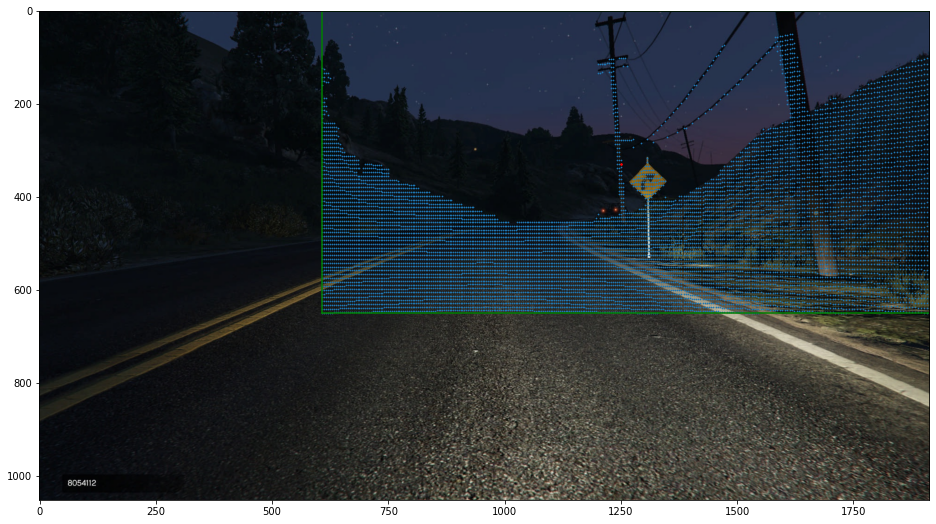

In [13]:
# load in testing data
test_imgs = glob(DATA_PATH + "test/*/*_image.jpg")
idx = np.random.randint(0, len(test_imgs))


cpu_device = torch.device("cpu")

image = read_image(test_imgs[idx])
print(image.shape)
gpu_image = image.float().unsqueeze(0).to(device) * 1.0 / 255
outputs = model(gpu_image)

fig1 = plt.figure(1, figsize=(16, 9))
ax1 = fig1.add_subplot(1, 1, 1)

outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]

# for each image, load the point cloud, and take the closest point to the center of the bbox and assign it.
xyz = np.fromfile(test_imgs[idx].replace('_image.jpg', '_cloud.bin'), dtype=np.float32)
xyz = xyz.reshape([3, -1])
proj = np.fromfile(test_imgs[idx].replace('_image.jpg', '_proj.bin'), dtype=np.float32)
proj.resize([3, 4])

uv = proj @ np.vstack([xyz, np.ones_like(xyz[0, :])])
uv = uv / uv[2, :]
dist = np.linalg.norm(xyz, axis=0)
# ax1.scatter(uv[0, :], uv[1, :], c=dist, marker='.', s=1)

if len(outputs) > 0:
    if len(outputs[0]['boxes']) > 0:
        max_bbox = outputs[0]['boxes'][0].squeeze(0).detach().numpy()

        img_viz = image.numpy().transpose(1, 2, 0)
        top = [max_bbox[0], max_bbox[2], max_bbox[1], max_bbox[1]]
        left = [max_bbox[0], max_bbox[0], max_bbox[1], max_bbox[3]]
        right = [max_bbox[2], max_bbox[2], max_bbox[1], max_bbox[3]]
        bottom = [max_bbox[0], max_bbox[2], max_bbox[3], max_bbox[3]]

        ax1.plot(top[:2], top[-2:], color='green')
        ax1.plot(left[:2], left[-2:], color='green')
        ax1.plot(right[:2], right[-2:], color='green')
        ax1.plot(bottom[:2], bottom[-2:], color='green')
        
        # find points within bounding box
        xg = uv[0, uv[0, :] > max_bbox[0]]
        yg = uv[1, uv[0, :] > max_bbox[0]]
        xl = xg[xg < max_bbox[2]]
        yl = yg[xg < max_bbox[2]]
        xm = xl[yl > max_bbox[1]]
        ym = yl[yl > max_bbox[1]]
        xn = xm[ym < max_bbox[3]]
        yn = ym[ym < max_bbox[3]]
        ax1.scatter(xn, yn, marker='.', s=2)
        # y_vals = np.where(uv[1, :] > max_bbox[1] and uv[1, :] < max_bbox[3])

        # find closest point to center of bbox
        bbox_center = np.array([[max_bbox[0] + (max_bbox[2] - max_bbox[0]) / 2.0, max_bbox[1] + (max_bbox[3] - max_bbox[1]) / 2.0]]).T
        print(bbox_center.shape)
        
        # loop through points to find closest
        xn = np.array([xn])
        yn = np.array([yn])
        print(xn.shape, yn.shape)
        pts = np.vstack([xn, yn])

        reps = np.tile(bbox_center, [1, pts.shape[1]])
        diff = np.linalg.norm(reps - pts, axis=0)
        min_pt = pts[:, np.argmin(diff)] 
        
        # find where uv[0, :] = min_pr
        xlog = (uv[0, :] == min_pt[0])
        ylog = (uv[1, :] == min_pt[1])
        index = np.all([xlog, ylog], axis=0).nonzero()
    
        # Assign this value to be the centroid
        centroid = xyz[:, index]
        ax1.scatter(uv[0, index], uv[1, index], marker='.', s=10, c='red')
        
        # write to file
        
ax1.imshow(img_viz)



plt.show()

In [14]:
def test_outputs(model, filename, avg_centroid=[0,0,0]):
    # load in testing data
    test_imgs = glob(DATA_PATH + "test/*/*_image.jpg")
    if os.path.exists(filename):
        os.remove(filename)
    f = open(filename, 'w')
    f.write('guid/image/axis,value\n')
    for idx in range(0, len(test_imgs)):
        cpu_device = torch.device("cpu")

        image = read_image(test_imgs[idx])
        gpu_image = image.float().unsqueeze(0).to(device) * 1.0 / 255
        outputs = model(gpu_image)

        # for each image, load the point cloud, and take the closest point to the center of the bbox and assign it.
        xyz = np.fromfile(test_imgs[idx].replace('_image.jpg', '_cloud.bin'), dtype=np.float32)
        xyz = xyz.reshape([3, -1])
        proj = np.fromfile(test_imgs[idx].replace('_image.jpg', '_proj.bin'), dtype=np.float32)
        proj.resize([3, 4])

        uv = proj @ np.vstack([xyz, np.ones_like(xyz[0, :])])
        uv = uv / uv[2, :]
        centroid = avg_centroid
        if len(outputs) > 0:
            if len(outputs[0]['boxes']) > 0:
                max_bbox = outputs[0]['boxes'][0].squeeze(0).detach().cpu().numpy()

                img_viz = image.numpy().transpose(1, 2, 0)
                top = [max_bbox[0], max_bbox[2], max_bbox[1], max_bbox[1]]
                left = [max_bbox[0], max_bbox[0], max_bbox[1], max_bbox[3]]
                right = [max_bbox[2], max_bbox[2], max_bbox[1], max_bbox[3]]
                bottom = [max_bbox[0], max_bbox[2], max_bbox[3], max_bbox[3]]

                ax1.plot(top[:2], top[-2:], color='green')
                ax1.plot(left[:2], left[-2:], color='green')
                ax1.plot(right[:2], right[-2:], color='green')
                ax1.plot(bottom[:2], bottom[-2:], color='green')

                # find points within bounding box
                xg = uv[0, uv[0, :] > max_bbox[0]]
                yg = uv[1, uv[0, :] > max_bbox[0]]
                xl = xg[xg < max_bbox[2]]
                yl = yg[xg < max_bbox[2]]
                xm = xl[yl > max_bbox[1]]
                ym = yl[yl > max_bbox[1]]
                xn = xm[ym < max_bbox[3]]
                yn = ym[ym < max_bbox[3]]
                # ax1.scatter(xn, yn, marker='.', s=2)
                # y_vals = np.where(uv[1, :] > max_bbox[1] and uv[1, :] < max_bbox[3])

                # find closest point to center of bbox
                bbox_center = np.array([[max_bbox[0] + (max_bbox[2] - max_bbox[0]) / 2.0, max_bbox[1] + (max_bbox[3] - max_bbox[1]) / 2.0]]).T

                # loop through points to find closest
                xn = np.array([xn])
                yn = np.array([yn])
                pts = np.vstack([xn, yn])
                if pts.shape[1] > 0:
                    reps = np.tile(bbox_center, [1, pts.shape[1]])
                    diff = np.linalg.norm(reps - pts, axis=0)
                    min_pt = pts[:, np.argmin(diff)] 

                    # find where uv[0, :] = min_pr
                    xlog = (uv[0, :] == min_pt[0])
                    ylog = (uv[1, :] == min_pt[1])
                    index = np.all([xlog, ylog], axis=0).nonzero()

                    # Assign this value to be the centroid
                    centroid = xyz[:, index].squeeze()

        # get guid
        guid = test_imgs[idx].split('/')[-2]
        index_num = test_imgs[idx].split('/')[-1].split('_')[0]
        print(f"{guid}/{index_num}")
        f.write(f"{guid}/{index_num}/x,{centroid[0]}\n")
        f.write(f"{guid}/{index_num}/y,{centroid[1]}\n")
        f.write(f"{guid}/{index_num}/z,{centroid[2]}\n")        
    f.close()
    
            
    

In [15]:
test_outputs(model, 'task2_submission1.csv', avg_centroid=[-1.448003444373406, -1.7046494727975137, 24.54205491312801])

e994ecfb-56d1-4704-ab7c-7d0e2ac7c21b/0003
e994ecfb-56d1-4704-ab7c-7d0e2ac7c21b/0102
e994ecfb-56d1-4704-ab7c-7d0e2ac7c21b/0068
e994ecfb-56d1-4704-ab7c-7d0e2ac7c21b/0061
e994ecfb-56d1-4704-ab7c-7d0e2ac7c21b/0097
e994ecfb-56d1-4704-ab7c-7d0e2ac7c21b/0094
e994ecfb-56d1-4704-ab7c-7d0e2ac7c21b/0063
e994ecfb-56d1-4704-ab7c-7d0e2ac7c21b/0039
e994ecfb-56d1-4704-ab7c-7d0e2ac7c21b/0028
e994ecfb-56d1-4704-ab7c-7d0e2ac7c21b/0013
e994ecfb-56d1-4704-ab7c-7d0e2ac7c21b/0050
e994ecfb-56d1-4704-ab7c-7d0e2ac7c21b/0059
e994ecfb-56d1-4704-ab7c-7d0e2ac7c21b/0090
e994ecfb-56d1-4704-ab7c-7d0e2ac7c21b/0082
e994ecfb-56d1-4704-ab7c-7d0e2ac7c21b/0027
e994ecfb-56d1-4704-ab7c-7d0e2ac7c21b/0037
e994ecfb-56d1-4704-ab7c-7d0e2ac7c21b/0055
e994ecfb-56d1-4704-ab7c-7d0e2ac7c21b/0008
e994ecfb-56d1-4704-ab7c-7d0e2ac7c21b/0100
e994ecfb-56d1-4704-ab7c-7d0e2ac7c21b/0001
e994ecfb-56d1-4704-ab7c-7d0e2ac7c21b/0052
e994ecfb-56d1-4704-ab7c-7d0e2ac7c21b/0087
e994ecfb-56d1-4704-ab7c-7d0e2ac7c21b/0080
e994ecfb-56d1-4704-ab7c-7d0e2ac7c2

0729ab2d-7fb0-4799-975f-c38fd350bf9c/0080
0729ab2d-7fb0-4799-975f-c38fd350bf9c/0056
0729ab2d-7fb0-4799-975f-c38fd350bf9c/0081
0729ab2d-7fb0-4799-975f-c38fd350bf9c/0019
0729ab2d-7fb0-4799-975f-c38fd350bf9c/0091
0729ab2d-7fb0-4799-975f-c38fd350bf9c/0026
0729ab2d-7fb0-4799-975f-c38fd350bf9c/0089
0729ab2d-7fb0-4799-975f-c38fd350bf9c/0044
0729ab2d-7fb0-4799-975f-c38fd350bf9c/0020
0729ab2d-7fb0-4799-975f-c38fd350bf9c/0035
0729ab2d-7fb0-4799-975f-c38fd350bf9c/0007
0729ab2d-7fb0-4799-975f-c38fd350bf9c/0072
0729ab2d-7fb0-4799-975f-c38fd350bf9c/0006
0729ab2d-7fb0-4799-975f-c38fd350bf9c/0029
0729ab2d-7fb0-4799-975f-c38fd350bf9c/0088
0729ab2d-7fb0-4799-975f-c38fd350bf9c/0004
0729ab2d-7fb0-4799-975f-c38fd350bf9c/0041
0729ab2d-7fb0-4799-975f-c38fd350bf9c/0018
0729ab2d-7fb0-4799-975f-c38fd350bf9c/0048
0729ab2d-7fb0-4799-975f-c38fd350bf9c/0062
0729ab2d-7fb0-4799-975f-c38fd350bf9c/0069
0729ab2d-7fb0-4799-975f-c38fd350bf9c/0076
0729ab2d-7fb0-4799-975f-c38fd350bf9c/0043
0729ab2d-7fb0-4799-975f-c38fd350bf

970fdcc0-a7d2-494b-bbed-5660aaf1f7c7/0114
970fdcc0-a7d2-494b-bbed-5660aaf1f7c7/0154
970fdcc0-a7d2-494b-bbed-5660aaf1f7c7/0095
970fdcc0-a7d2-494b-bbed-5660aaf1f7c7/0109
970fdcc0-a7d2-494b-bbed-5660aaf1f7c7/0085
970fdcc0-a7d2-494b-bbed-5660aaf1f7c7/0146
970fdcc0-a7d2-494b-bbed-5660aaf1f7c7/0127
970fdcc0-a7d2-494b-bbed-5660aaf1f7c7/0178
970fdcc0-a7d2-494b-bbed-5660aaf1f7c7/0040
970fdcc0-a7d2-494b-bbed-5660aaf1f7c7/0021
970fdcc0-a7d2-494b-bbed-5660aaf1f7c7/0157
970fdcc0-a7d2-494b-bbed-5660aaf1f7c7/0086
970fdcc0-a7d2-494b-bbed-5660aaf1f7c7/0051
970fdcc0-a7d2-494b-bbed-5660aaf1f7c7/0054
970fdcc0-a7d2-494b-bbed-5660aaf1f7c7/0176
970fdcc0-a7d2-494b-bbed-5660aaf1f7c7/0129
970fdcc0-a7d2-494b-bbed-5660aaf1f7c7/0108
970fdcc0-a7d2-494b-bbed-5660aaf1f7c7/0053
970fdcc0-a7d2-494b-bbed-5660aaf1f7c7/0075
970fdcc0-a7d2-494b-bbed-5660aaf1f7c7/0160
970fdcc0-a7d2-494b-bbed-5660aaf1f7c7/0070
970fdcc0-a7d2-494b-bbed-5660aaf1f7c7/0058
970fdcc0-a7d2-494b-bbed-5660aaf1f7c7/0101
970fdcc0-a7d2-494b-bbed-5660aaf1f7

0ff0a23e-5f50-4461-8ccf-2b71bead2e8e/0137
0ff0a23e-5f50-4461-8ccf-2b71bead2e8e/0028
0ff0a23e-5f50-4461-8ccf-2b71bead2e8e/0013
0ff0a23e-5f50-4461-8ccf-2b71bead2e8e/0050
0ff0a23e-5f50-4461-8ccf-2b71bead2e8e/0119
0ff0a23e-5f50-4461-8ccf-2b71bead2e8e/0059
0ff0a23e-5f50-4461-8ccf-2b71bead2e8e/0090
0ff0a23e-5f50-4461-8ccf-2b71bead2e8e/0130
0ff0a23e-5f50-4461-8ccf-2b71bead2e8e/0082
0ff0a23e-5f50-4461-8ccf-2b71bead2e8e/0027
0ff0a23e-5f50-4461-8ccf-2b71bead2e8e/0037
0ff0a23e-5f50-4461-8ccf-2b71bead2e8e/0055
0ff0a23e-5f50-4461-8ccf-2b71bead2e8e/0008
0ff0a23e-5f50-4461-8ccf-2b71bead2e8e/0100
0ff0a23e-5f50-4461-8ccf-2b71bead2e8e/0001
0ff0a23e-5f50-4461-8ccf-2b71bead2e8e/0115
0ff0a23e-5f50-4461-8ccf-2b71bead2e8e/0052
0ff0a23e-5f50-4461-8ccf-2b71bead2e8e/0087
0ff0a23e-5f50-4461-8ccf-2b71bead2e8e/0080
0ff0a23e-5f50-4461-8ccf-2b71bead2e8e/0056
0ff0a23e-5f50-4461-8ccf-2b71bead2e8e/0081
0ff0a23e-5f50-4461-8ccf-2b71bead2e8e/0096
0ff0a23e-5f50-4461-8ccf-2b71bead2e8e/0113
0ff0a23e-5f50-4461-8ccf-2b71bead2e

73dd2560-1057-4a74-ad6c-431079e2d054/0057
73dd2560-1057-4a74-ad6c-431079e2d054/0023
73dd2560-1057-4a74-ad6c-431079e2d054/0009
73dd2560-1057-4a74-ad6c-431079e2d054/0099
73dd2560-1057-4a74-ad6c-431079e2d054/0083
73dd2560-1057-4a74-ad6c-431079e2d054/0038
73dd2560-1057-4a74-ad6c-431079e2d054/0016
73dd2560-1057-4a74-ad6c-431079e2d054/0067
73dd2560-1057-4a74-ad6c-431079e2d054/0014
73dd2560-1057-4a74-ad6c-431079e2d054/0005
73dd2560-1057-4a74-ad6c-431079e2d054/0049
73dd2560-1057-4a74-ad6c-431079e2d054/0012
73dd2560-1057-4a74-ad6c-431079e2d054/0095
73dd2560-1057-4a74-ad6c-431079e2d054/0085
73dd2560-1057-4a74-ad6c-431079e2d054/0040
73dd2560-1057-4a74-ad6c-431079e2d054/0021
73dd2560-1057-4a74-ad6c-431079e2d054/0086
73dd2560-1057-4a74-ad6c-431079e2d054/0051
73dd2560-1057-4a74-ad6c-431079e2d054/0054
73dd2560-1057-4a74-ad6c-431079e2d054/0053
73dd2560-1057-4a74-ad6c-431079e2d054/0075
73dd2560-1057-4a74-ad6c-431079e2d054/0070
73dd2560-1057-4a74-ad6c-431079e2d054/0058
73dd2560-1057-4a74-ad6c-431079e2d0

0410e7f5-4bfd-4d35-b623-9f8d6b87c179/0009
0410e7f5-4bfd-4d35-b623-9f8d6b87c179/0038
0410e7f5-4bfd-4d35-b623-9f8d6b87c179/0016
0410e7f5-4bfd-4d35-b623-9f8d6b87c179/0014
0410e7f5-4bfd-4d35-b623-9f8d6b87c179/0005
0410e7f5-4bfd-4d35-b623-9f8d6b87c179/0049
0410e7f5-4bfd-4d35-b623-9f8d6b87c179/0012
0410e7f5-4bfd-4d35-b623-9f8d6b87c179/0040
0410e7f5-4bfd-4d35-b623-9f8d6b87c179/0021
0410e7f5-4bfd-4d35-b623-9f8d6b87c179/0051
0410e7f5-4bfd-4d35-b623-9f8d6b87c179/0033
0410e7f5-4bfd-4d35-b623-9f8d6b87c179/0032
0410e7f5-4bfd-4d35-b623-9f8d6b87c179/0042
0410e7f5-4bfd-4d35-b623-9f8d6b87c179/0010
0410e7f5-4bfd-4d35-b623-9f8d6b87c179/0034
0410e7f5-4bfd-4d35-b623-9f8d6b87c179/0015
0410e7f5-4bfd-4d35-b623-9f8d6b87c179/0024
0410e7f5-4bfd-4d35-b623-9f8d6b87c179/0022
0410e7f5-4bfd-4d35-b623-9f8d6b87c179/0011
0410e7f5-4bfd-4d35-b623-9f8d6b87c179/0045
0410e7f5-4bfd-4d35-b623-9f8d6b87c179/0000
0410e7f5-4bfd-4d35-b623-9f8d6b87c179/0046
42f4f79e-caa5-4702-b54d-d48fa4e7ab1b/0003
42f4f79e-caa5-4702-b54d-d48fa4e7ab

d78f61da-03c8-4f39-b843-f3f93be3da2f/0112
d78f61da-03c8-4f39-b843-f3f93be3da2f/0125
d78f61da-03c8-4f39-b843-f3f93be3da2f/0014
d78f61da-03c8-4f39-b843-f3f93be3da2f/0128
d78f61da-03c8-4f39-b843-f3f93be3da2f/0170
d78f61da-03c8-4f39-b843-f3f93be3da2f/0005
d78f61da-03c8-4f39-b843-f3f93be3da2f/0049
d78f61da-03c8-4f39-b843-f3f93be3da2f/0012
d78f61da-03c8-4f39-b843-f3f93be3da2f/0114
d78f61da-03c8-4f39-b843-f3f93be3da2f/0154
d78f61da-03c8-4f39-b843-f3f93be3da2f/0095
d78f61da-03c8-4f39-b843-f3f93be3da2f/0109
d78f61da-03c8-4f39-b843-f3f93be3da2f/0085
d78f61da-03c8-4f39-b843-f3f93be3da2f/0146
d78f61da-03c8-4f39-b843-f3f93be3da2f/0127
d78f61da-03c8-4f39-b843-f3f93be3da2f/0178
d78f61da-03c8-4f39-b843-f3f93be3da2f/0040
d78f61da-03c8-4f39-b843-f3f93be3da2f/0021
d78f61da-03c8-4f39-b843-f3f93be3da2f/0157
d78f61da-03c8-4f39-b843-f3f93be3da2f/0086
d78f61da-03c8-4f39-b843-f3f93be3da2f/0051
d78f61da-03c8-4f39-b843-f3f93be3da2f/0054
d78f61da-03c8-4f39-b843-f3f93be3da2f/0176
d78f61da-03c8-4f39-b843-f3f93be3da

cc9b0ffb-4041-4a90-82cf-992e88249b9b/0069
cc9b0ffb-4041-4a90-82cf-992e88249b9b/0076
cc9b0ffb-4041-4a90-82cf-992e88249b9b/0043
cc9b0ffb-4041-4a90-82cf-992e88249b9b/0093
cc9b0ffb-4041-4a90-82cf-992e88249b9b/0031
cc9b0ffb-4041-4a90-82cf-992e88249b9b/0025
cc9b0ffb-4041-4a90-82cf-992e88249b9b/0079
cc9b0ffb-4041-4a90-82cf-992e88249b9b/0047
cc9b0ffb-4041-4a90-82cf-992e88249b9b/0074
cc9b0ffb-4041-4a90-82cf-992e88249b9b/0073
cc9b0ffb-4041-4a90-82cf-992e88249b9b/0065
cc9b0ffb-4041-4a90-82cf-992e88249b9b/0071
cc9b0ffb-4041-4a90-82cf-992e88249b9b/0017
cc9b0ffb-4041-4a90-82cf-992e88249b9b/0030
cc9b0ffb-4041-4a90-82cf-992e88249b9b/0036
cc9b0ffb-4041-4a90-82cf-992e88249b9b/0077
cc9b0ffb-4041-4a90-82cf-992e88249b9b/0002
cc9b0ffb-4041-4a90-82cf-992e88249b9b/0057
cc9b0ffb-4041-4a90-82cf-992e88249b9b/0023
cc9b0ffb-4041-4a90-82cf-992e88249b9b/0009
cc9b0ffb-4041-4a90-82cf-992e88249b9b/0099
cc9b0ffb-4041-4a90-82cf-992e88249b9b/0083
cc9b0ffb-4041-4a90-82cf-992e88249b9b/0038
cc9b0ffb-4041-4a90-82cf-992e88249b

5375f8e6-96e9-4f49-97ff-d5df95f12464/0127
5375f8e6-96e9-4f49-97ff-d5df95f12464/0178
5375f8e6-96e9-4f49-97ff-d5df95f12464/0040
5375f8e6-96e9-4f49-97ff-d5df95f12464/0021
5375f8e6-96e9-4f49-97ff-d5df95f12464/0157
5375f8e6-96e9-4f49-97ff-d5df95f12464/0086
5375f8e6-96e9-4f49-97ff-d5df95f12464/0051
5375f8e6-96e9-4f49-97ff-d5df95f12464/0054
5375f8e6-96e9-4f49-97ff-d5df95f12464/0176
5375f8e6-96e9-4f49-97ff-d5df95f12464/0129
5375f8e6-96e9-4f49-97ff-d5df95f12464/0108
5375f8e6-96e9-4f49-97ff-d5df95f12464/0053
5375f8e6-96e9-4f49-97ff-d5df95f12464/0075
5375f8e6-96e9-4f49-97ff-d5df95f12464/0160
5375f8e6-96e9-4f49-97ff-d5df95f12464/0070
5375f8e6-96e9-4f49-97ff-d5df95f12464/0058
5375f8e6-96e9-4f49-97ff-d5df95f12464/0101
5375f8e6-96e9-4f49-97ff-d5df95f12464/0142
5375f8e6-96e9-4f49-97ff-d5df95f12464/0033
5375f8e6-96e9-4f49-97ff-d5df95f12464/0032
5375f8e6-96e9-4f49-97ff-d5df95f12464/0042
5375f8e6-96e9-4f49-97ff-d5df95f12464/0148
5375f8e6-96e9-4f49-97ff-d5df95f12464/0162
5375f8e6-96e9-4f49-97ff-d5df95f124

56b6bc82-8545-4ac9-a5da-fc0c1f899b45/0015
56b6bc82-8545-4ac9-a5da-fc0c1f899b45/0064
56b6bc82-8545-4ac9-a5da-fc0c1f899b45/0106
56b6bc82-8545-4ac9-a5da-fc0c1f899b45/0147
56b6bc82-8545-4ac9-a5da-fc0c1f899b45/0138
56b6bc82-8545-4ac9-a5da-fc0c1f899b45/0098
56b6bc82-8545-4ac9-a5da-fc0c1f899b45/0152
56b6bc82-8545-4ac9-a5da-fc0c1f899b45/0066
56b6bc82-8545-4ac9-a5da-fc0c1f899b45/0024
56b6bc82-8545-4ac9-a5da-fc0c1f899b45/0156
56b6bc82-8545-4ac9-a5da-fc0c1f899b45/0122
56b6bc82-8545-4ac9-a5da-fc0c1f899b45/0145
56b6bc82-8545-4ac9-a5da-fc0c1f899b45/0132
56b6bc82-8545-4ac9-a5da-fc0c1f899b45/0134
56b6bc82-8545-4ac9-a5da-fc0c1f899b45/0022
56b6bc82-8545-4ac9-a5da-fc0c1f899b45/0118
56b6bc82-8545-4ac9-a5da-fc0c1f899b45/0139
56b6bc82-8545-4ac9-a5da-fc0c1f899b45/0084
56b6bc82-8545-4ac9-a5da-fc0c1f899b45/0011
56b6bc82-8545-4ac9-a5da-fc0c1f899b45/0045
56b6bc82-8545-4ac9-a5da-fc0c1f899b45/0165
56b6bc82-8545-4ac9-a5da-fc0c1f899b45/0078
56b6bc82-8545-4ac9-a5da-fc0c1f899b45/0121
56b6bc82-8545-4ac9-a5da-fc0c1f899b

748e842e-ed85-45ca-b8f1-4acdcb76f3eb/0070
748e842e-ed85-45ca-b8f1-4acdcb76f3eb/0058
748e842e-ed85-45ca-b8f1-4acdcb76f3eb/0101
748e842e-ed85-45ca-b8f1-4acdcb76f3eb/0142
748e842e-ed85-45ca-b8f1-4acdcb76f3eb/0033
748e842e-ed85-45ca-b8f1-4acdcb76f3eb/0032
748e842e-ed85-45ca-b8f1-4acdcb76f3eb/0042
748e842e-ed85-45ca-b8f1-4acdcb76f3eb/0204
748e842e-ed85-45ca-b8f1-4acdcb76f3eb/0148
748e842e-ed85-45ca-b8f1-4acdcb76f3eb/0162
748e842e-ed85-45ca-b8f1-4acdcb76f3eb/0010
748e842e-ed85-45ca-b8f1-4acdcb76f3eb/0143
748e842e-ed85-45ca-b8f1-4acdcb76f3eb/0105
748e842e-ed85-45ca-b8f1-4acdcb76f3eb/0034
748e842e-ed85-45ca-b8f1-4acdcb76f3eb/0212
748e842e-ed85-45ca-b8f1-4acdcb76f3eb/0015
748e842e-ed85-45ca-b8f1-4acdcb76f3eb/0064
748e842e-ed85-45ca-b8f1-4acdcb76f3eb/0106
748e842e-ed85-45ca-b8f1-4acdcb76f3eb/0147
748e842e-ed85-45ca-b8f1-4acdcb76f3eb/0218
748e842e-ed85-45ca-b8f1-4acdcb76f3eb/0213
748e842e-ed85-45ca-b8f1-4acdcb76f3eb/0138
748e842e-ed85-45ca-b8f1-4acdcb76f3eb/0098
748e842e-ed85-45ca-b8f1-4acdcb76f3

b1d5b43f-be5d-4cf2-84bf-dc9366a6d9e0/0020
b1d5b43f-be5d-4cf2-84bf-dc9366a6d9e0/0035
b1d5b43f-be5d-4cf2-84bf-dc9366a6d9e0/0255
b1d5b43f-be5d-4cf2-84bf-dc9366a6d9e0/0181
b1d5b43f-be5d-4cf2-84bf-dc9366a6d9e0/0007
b1d5b43f-be5d-4cf2-84bf-dc9366a6d9e0/0224
b1d5b43f-be5d-4cf2-84bf-dc9366a6d9e0/0221
b1d5b43f-be5d-4cf2-84bf-dc9366a6d9e0/0072
b1d5b43f-be5d-4cf2-84bf-dc9366a6d9e0/0140
b1d5b43f-be5d-4cf2-84bf-dc9366a6d9e0/0131
b1d5b43f-be5d-4cf2-84bf-dc9366a6d9e0/0124
b1d5b43f-be5d-4cf2-84bf-dc9366a6d9e0/0006
b1d5b43f-be5d-4cf2-84bf-dc9366a6d9e0/0029
b1d5b43f-be5d-4cf2-84bf-dc9366a6d9e0/0088
b1d5b43f-be5d-4cf2-84bf-dc9366a6d9e0/0004
b1d5b43f-be5d-4cf2-84bf-dc9366a6d9e0/0180
b1d5b43f-be5d-4cf2-84bf-dc9366a6d9e0/0141
b1d5b43f-be5d-4cf2-84bf-dc9366a6d9e0/0041
b1d5b43f-be5d-4cf2-84bf-dc9366a6d9e0/0228
b1d5b43f-be5d-4cf2-84bf-dc9366a6d9e0/0018
b1d5b43f-be5d-4cf2-84bf-dc9366a6d9e0/0048
b1d5b43f-be5d-4cf2-84bf-dc9366a6d9e0/0126
b1d5b43f-be5d-4cf2-84bf-dc9366a6d9e0/0062
b1d5b43f-be5d-4cf2-84bf-dc9366a6d9

301c7467-993f-4ce5-9952-1f9ab29e0992/0008
301c7467-993f-4ce5-9952-1f9ab29e0992/0001
301c7467-993f-4ce5-9952-1f9ab29e0992/0019
301c7467-993f-4ce5-9952-1f9ab29e0992/0026
301c7467-993f-4ce5-9952-1f9ab29e0992/0044
301c7467-993f-4ce5-9952-1f9ab29e0992/0020
301c7467-993f-4ce5-9952-1f9ab29e0992/0035
301c7467-993f-4ce5-9952-1f9ab29e0992/0007
301c7467-993f-4ce5-9952-1f9ab29e0992/0006
301c7467-993f-4ce5-9952-1f9ab29e0992/0029
301c7467-993f-4ce5-9952-1f9ab29e0992/0004
301c7467-993f-4ce5-9952-1f9ab29e0992/0041
301c7467-993f-4ce5-9952-1f9ab29e0992/0018
301c7467-993f-4ce5-9952-1f9ab29e0992/0048
301c7467-993f-4ce5-9952-1f9ab29e0992/0043
301c7467-993f-4ce5-9952-1f9ab29e0992/0031
301c7467-993f-4ce5-9952-1f9ab29e0992/0025
301c7467-993f-4ce5-9952-1f9ab29e0992/0047
301c7467-993f-4ce5-9952-1f9ab29e0992/0017
301c7467-993f-4ce5-9952-1f9ab29e0992/0030
301c7467-993f-4ce5-9952-1f9ab29e0992/0036
301c7467-993f-4ce5-9952-1f9ab29e0992/0002
301c7467-993f-4ce5-9952-1f9ab29e0992/0023
301c7467-993f-4ce5-9952-1f9ab29e09

effc00fc-f301-4971-bb8a-de2261a1db25/0077
effc00fc-f301-4971-bb8a-de2261a1db25/0002
effc00fc-f301-4971-bb8a-de2261a1db25/0057
effc00fc-f301-4971-bb8a-de2261a1db25/0107
effc00fc-f301-4971-bb8a-de2261a1db25/0023
effc00fc-f301-4971-bb8a-de2261a1db25/0104
effc00fc-f301-4971-bb8a-de2261a1db25/0136
effc00fc-f301-4971-bb8a-de2261a1db25/0009
effc00fc-f301-4971-bb8a-de2261a1db25/0099
effc00fc-f301-4971-bb8a-de2261a1db25/0083
effc00fc-f301-4971-bb8a-de2261a1db25/0038
effc00fc-f301-4971-bb8a-de2261a1db25/0016
effc00fc-f301-4971-bb8a-de2261a1db25/0117
effc00fc-f301-4971-bb8a-de2261a1db25/0067
effc00fc-f301-4971-bb8a-de2261a1db25/0112
effc00fc-f301-4971-bb8a-de2261a1db25/0125
effc00fc-f301-4971-bb8a-de2261a1db25/0014
effc00fc-f301-4971-bb8a-de2261a1db25/0128
effc00fc-f301-4971-bb8a-de2261a1db25/0005
effc00fc-f301-4971-bb8a-de2261a1db25/0049
effc00fc-f301-4971-bb8a-de2261a1db25/0012
effc00fc-f301-4971-bb8a-de2261a1db25/0114
effc00fc-f301-4971-bb8a-de2261a1db25/0095
effc00fc-f301-4971-bb8a-de2261a1db